### Version 3, since we'll be modularizing our code, and v2 is really just a refined version of v1

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [2]:
words = open('../names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [3]:
block_size = 3

def build_dataset(words, block_size):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    # split up dataset
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8*X.shape[0])
    n2 = int(0.9*X.shape[0])
    Xtr, Xdev, Xte = X.tensor_split((n1, n2), dim=0)
    Ytr, Ydev, Yte = Y.tensor_split((n1, n2), dim=0)
    
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte 

Xtr, Ytr, Xdev, Ydev, Xte, Yte = build_dataset(words, block_size)
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape

(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22815, 3]),
 torch.Size([22815]),
 torch.Size([22815, 3]),
 torch.Size([22815]))

### Linear layer class definition

In [4]:
class Linear:
    def __init__(
        self, 
        fan_in, # number of inputs coming into the linear layer (spread like a fan)
        fan_out, # number of outputs coming out of the linear layer (spread out like a fan)
        g=torch.Generator().manual_seed(2147483647), # generator for weights for Andrej reproducibility
        bias=True # bias constants are defaulted to be true         
    ) -> None:
        '''
        initialize the linear layer
        '''
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    
    def __call__(self, x):
        ''' 
        __call__ allows you to call the class like a function to do something
        in this case, when providing an input, __call__ will provide an output of the linear layer 
        '''
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        ''' 
        __call__ allows you to call the class like a function to do something
        in this case, when providing an input, __call__ will provide an output of the linear layer 
        '''
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [5]:
class BatchNorm1D:
    def __init__(
        self,
        dim, # number of features that the batchnorm layer will have
        eps=1e-5,  # epsilon--keeps std well-behaved when its value hovers around 0
        momentum=0.1 # increment used for updating the running mean and std
    ) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True # boolean for whether we are training or testing the model
        # parameters trained through back propogation, in PyTorch notation
        # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # ---------------------------
        self.gamma = torch.ones(dim) # gain
        self.beta = torch.zeros(dim) # biases
        # ---------------------------
        # "buffers" which are trained through a running 'momentum-based update'
        # ---------------------------
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        # ---------------------------

        
    def __call__(self, x):
        '''
        calculate the Forward pass for the input x
        '''
        if self.training: # if we're training the model, calculate mean
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else: # if we're validating or testing our model, use running quantities
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize input to unit variance
        self.out = self.gamma * xhat + self.beta # normally not in pytorch, but we want statistics
        
        # update the buffers while we're training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum * xvar
        return self.out 

    def parameters(self):
        return [self.gamma, self.beta]

In [6]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [119]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g) # embedding tensor
layers = [ # one linear layer, then four hidden layers, then one output layer = 6 layer MLP
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), Tanh(),
    Linear(n_hidden,           vocab_size),
]

with torch.no_grad():
    layers[-1].weight += 0.1 # make the last layer less confident
    for layer in layers[:-1]: # apply gain to all other layers
        if isinstance(layer, Linear): # check whether, as we're iterating, we're looking at a layer
            layer.weight *= 5/3 # apply the gain factor according to tanh
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


### And now for the training step

In [120]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = [] # this is our update / data ratio list which will keep track of ratios between update and data

for i in range(max_steps):
    ### construct mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    ### forward pass
    emb = C[Xb] # embed all characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate all vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    ### backward pass
    for layer in layers:
        layer.out.retain_grad() # tells pytorch to keep gradient, useful for debugging
    for p in parameters:
        p.grad = None
    loss.backward()
    
    ### update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track where we are in the training
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
print('----------')        
print(f'final loss: {10**lossi[-1]}')

loss at step 0 of 200000: 3.4049
----------
final loss: 2.3161347691907155


layer 1 layer Tanh: mean -0.008, std 0.765, saturated 20.47%
layer 3 layer Tanh: mean 0.046, std 0.727, saturated 12.50%
layer 5 layer Tanh: mean 0.069, std 0.723, saturated 11.66%
layer 7 layer Tanh: mean -0.021, std 0.750, saturated 14.88%
layer 9 layer Tanh: mean 0.026, std 0.743, saturated 14.22%


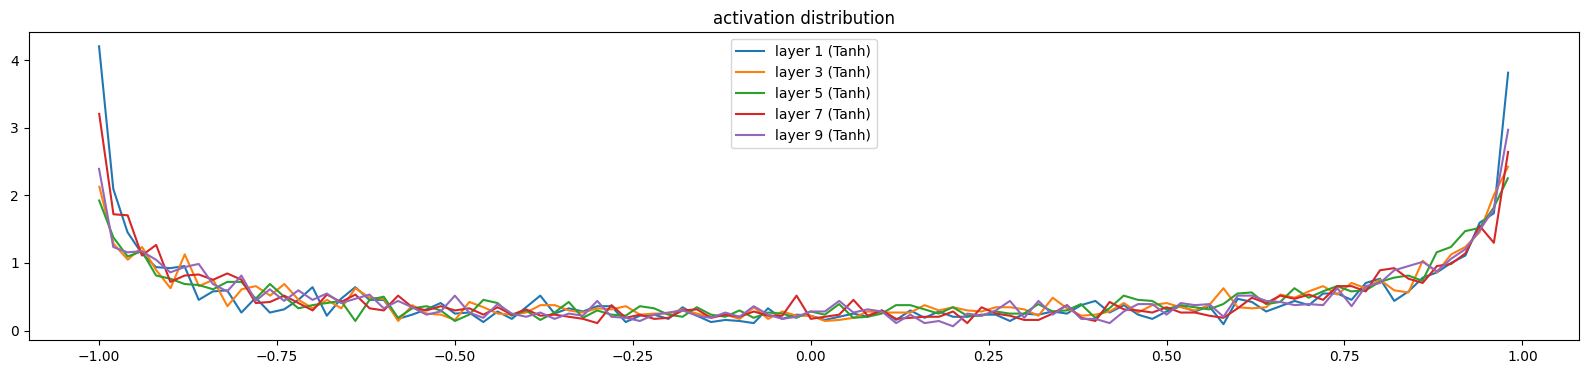

In [121]:
''' Now we're going to visualize the data with histograms '''
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('activation distribution');

This proves that 5/3 is a good gain factor because it's not too low of a gain where all of the values of tanh are getting squashed, but not large enough like 3 where there's too high of a gain and there's a lot of spread in the values

If at 1, we see that the variance (i.e. std) is shrinking, while there are basically no values that saturate, and everything is tending towards zero

If at 3, then the gain is huge, std is huge, and there's a large spread of the outputs

### Now let's look at what the gradients are doing within the first training step

layer 1 layer Tanh: mean 0.000, std 0.003, saturated 0.00%
layer 3 layer Tanh: mean 0.000, std 0.003, saturated 0.00%
layer 5 layer Tanh: mean -0.000, std 0.003, saturated 0.00%
layer 7 layer Tanh: mean -0.000, std 0.003, saturated 0.00%
layer 9 layer Tanh: mean -0.000, std 0.003, saturated 0.00%


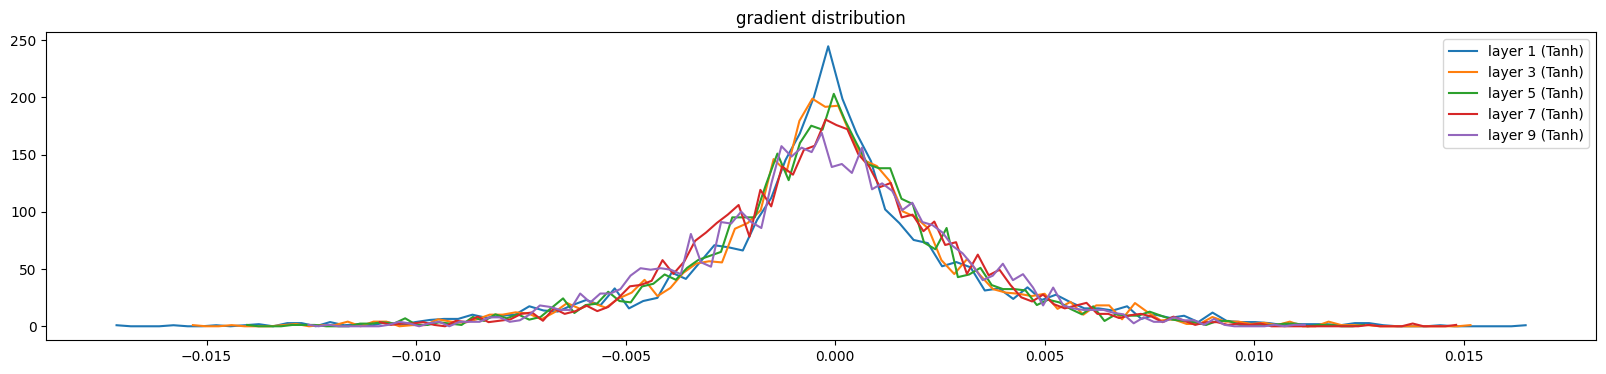

In [122]:
''' Now we're going to visualize the data with histograms '''
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('gradient distribution');

What we want to see is that the gradients in each layer are roughly the same, which means that the forces--both the squash and de-squash--are balanced out

## Now let's also look at what the weights are doing

weight (27, 10) mean -0.001, std 0.014, grad/data ratio: 0.01
weight (30, 100) mean 0.000, std 0.010, grad/data ratio: 0.03
weight (100, 100) mean 0.000, std 0.009, grad/data ratio: 0.05
weight (100, 100) mean -0.000, std 0.008, grad/data ratio: 0.05
weight (100, 100) mean 0.000, std 0.007, grad/data ratio: 0.04
weight (100, 100) mean 0.000, std 0.008, grad/data ratio: 0.05
weight (100, 27) mean 0.000, std 0.027, grad/data ratio: 0.25


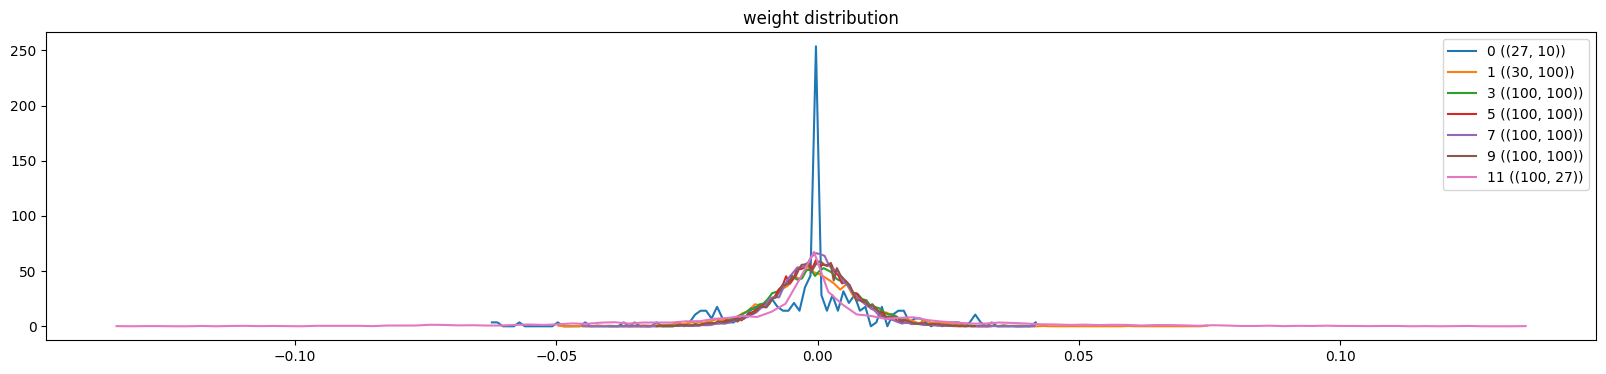

In [123]:
''' Now we're going to visualize the data with histograms '''
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # this is only true for anything that has two dimensions, i.e. the weights
        print(f'weight {tuple(p.shape)} mean {t.mean():.3f}, std {t.std():.3f}, grad/data ratio: {(t.std()/p.std()):.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
        legends.append(f'{i} ({tuple(p.shape)})')
    
plt.legend(legends);
plt.title('weight distribution');

Now the grad/data ratio isn't that informative because it's not really saying a whole lot. remember that in order to update the data, we use the lr*p.grad in the update step. so what we really need to be analyzing is the ratio between how large the update step is, to the data. this will give us a good idea about how much the data is changing due to the update step

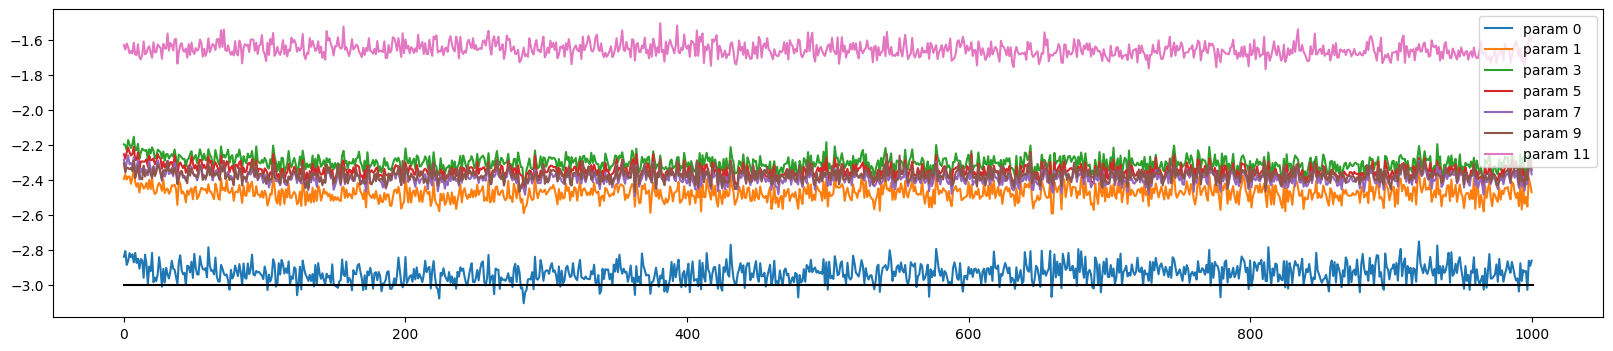

In [124]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') # we're expecting the ratios to be ~1e-3
plt.legend(legends);

My update/data ratio is a little differnet from Andrej's, but the punchline is that if I have these ratios that are below 1e-3, this means that the network is not training fast enough, and the update step is pretty small, meaning that the log of the ratio will be a larger negative number

What I'm getting is that the training is happening fast enough, and everything's going well

Now let's actually implement the layers that have the BatchNorm in it!

In [125]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g) # embedding tensor
layers = [ # one linear layer, then four hidden layers, then one output layer = 6 layer MLP
    Linear(n_embd*block_size, n_hidden),  BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    #layers[-1].weight += 0.1 # make the last layer less confident
    layers[-1].gamma += 0.1 # need to adjust gamma now since the last layer is batchnorm
    for layer in layers[:-1]: # apply gain to all other layers
        if isinstance(layer, Linear): # check whether, as we're iterating, we're looking at a layer
            layer.weight *= 5/3 # apply the gain factor according to tanh
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [126]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = [] # this is our update / data ratio list which will keep track of ratios between update and data

for i in range(max_steps):
    ### construct mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    ### forward pass
    emb = C[Xb] # embed all characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate all vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    ### backward pass
    for layer in layers:
        layer.out.retain_grad() # tells pytorch to keep gradient, useful for debugging
    for p in parameters:
        p.grad = None
    loss.backward()
    
    ### update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track where we are in the training
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
print('----------')        
print(f'final loss: {10**lossi[-1]}')

loss at step 0 of 200000: 3.8401
----------
final loss: 2.677746818201319


layer 2 layer Tanh: mean 0.003, std 0.630, saturated 3.03%
layer 5 layer Tanh: mean 0.006, std 0.636, saturated 2.47%
layer 8 layer Tanh: mean -0.002, std 0.645, saturated 2.62%
layer 11 layer Tanh: mean 0.006, std 0.649, saturated 2.31%
layer 14 layer Tanh: mean -0.001, std 0.651, saturated 1.78%


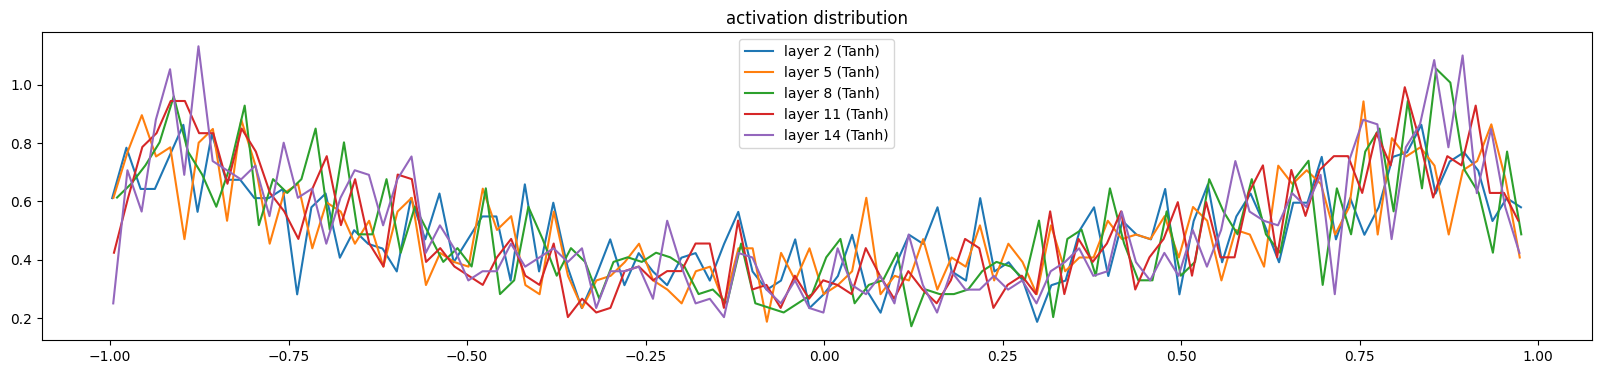

In [127]:
''' Now we're going to visualize the data with histograms '''
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('activation distribution');

These look great! Barely any squashing! This happens since there is a normalization in every batch, so this means that activations will basically be uniform

layer 2 layer Tanh: mean -0.000, std 0.003, saturated 0.00%
layer 5 layer Tanh: mean 0.000, std 0.003, saturated 0.00%
layer 8 layer Tanh: mean 0.000, std 0.003, saturated 0.00%
layer 11 layer Tanh: mean -0.000, std 0.003, saturated 0.00%
layer 14 layer Tanh: mean 0.000, std 0.003, saturated 0.00%


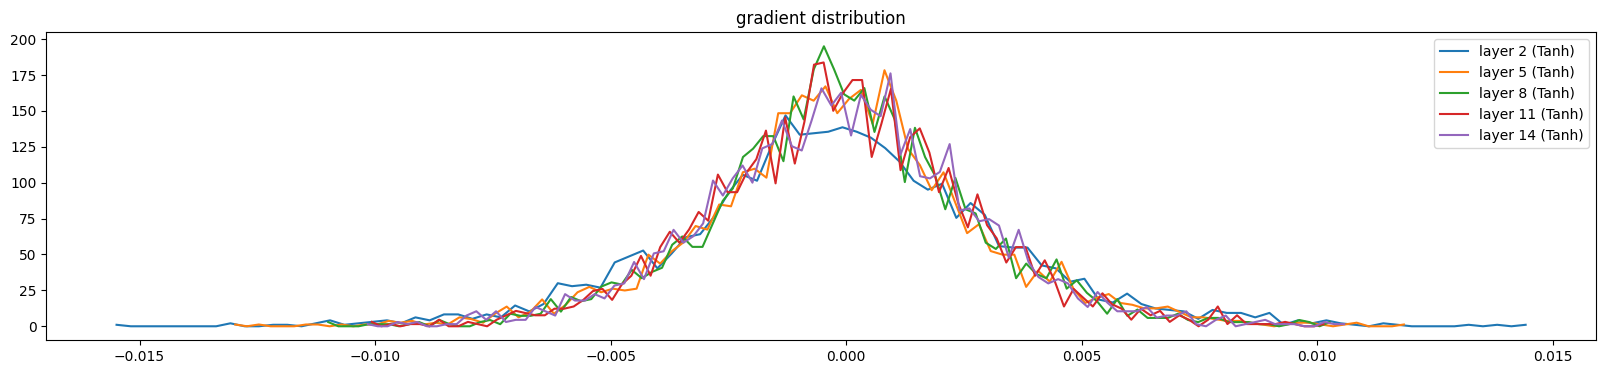

In [128]:
''' Now we're going to visualize the data with histograms '''
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('gradient distribution');

weight (27, 10) mean -0.000, std 0.010, grad/data ratio: 0.01
weight (30, 100) mean 0.000, std 0.008, grad/data ratio: 0.03
weight (100, 100) mean 0.000, std 0.007, grad/data ratio: 0.04
weight (100, 100) mean 0.000, std 0.006, grad/data ratio: 0.04
weight (100, 100) mean 0.000, std 0.006, grad/data ratio: 0.03
weight (100, 100) mean 0.000, std 0.006, grad/data ratio: 0.03
weight (100, 27) mean -0.000, std 0.011, grad/data ratio: 0.06


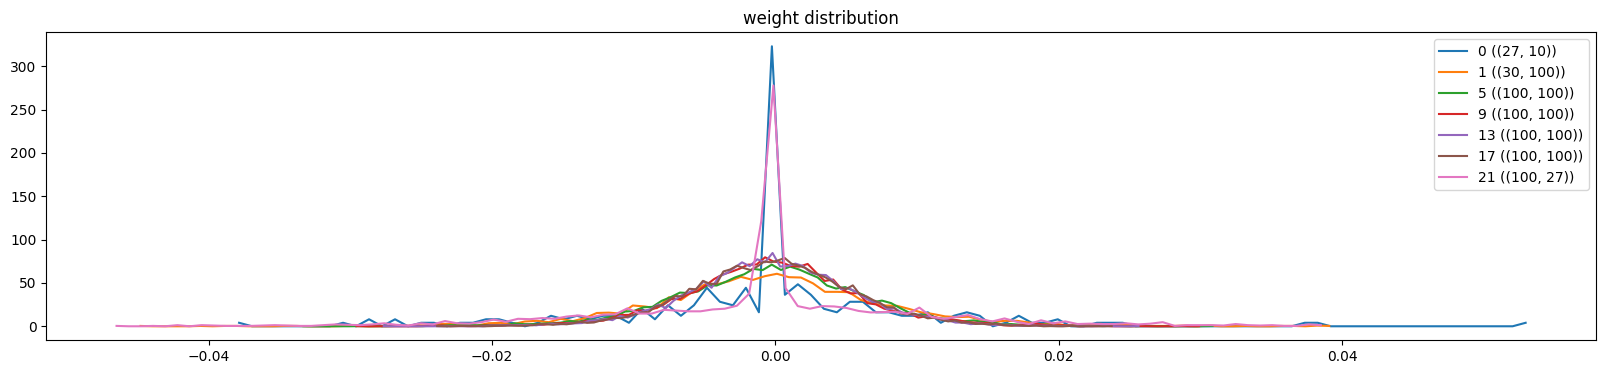

In [129]:
''' Now we're going to visualize the data with histograms '''
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # this is only true for anything that has two dimensions, i.e. the weights
        print(f'weight {tuple(p.shape)} mean {t.mean():.3f}, std {t.std():.3f}, grad/data ratio: {(t.std()/p.std()):.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
        legends.append(f'{i} ({tuple(p.shape)})')
    
plt.legend(legends);
plt.title('weight distribution');

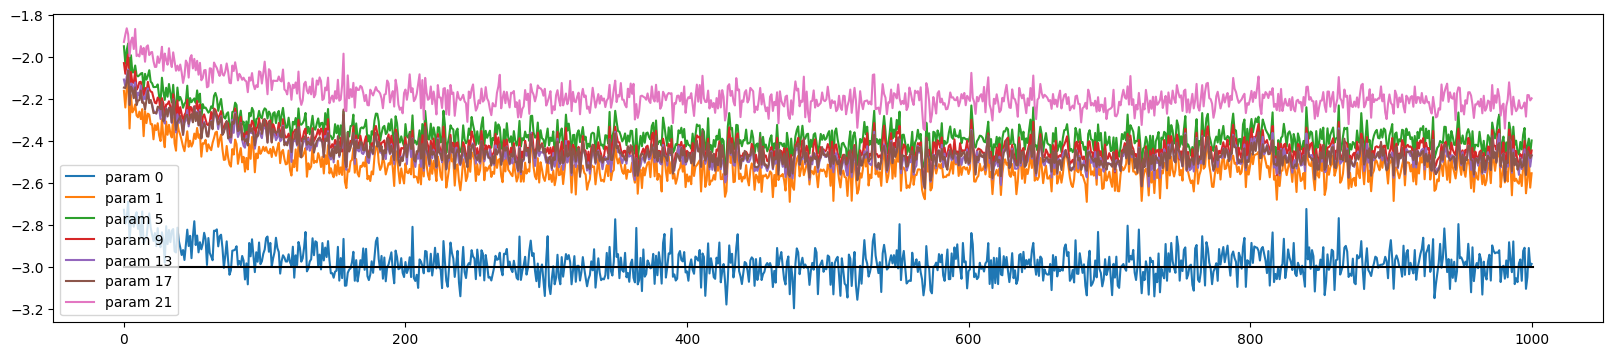

In [130]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') # we're expecting the ratios to be ~1e-3
plt.legend(legends);

My update curves look different but the deeper layers are converging to Andrej's values so that's good. It's confusing since I'm not reproducing his results even though I am using the same generator. I wonder if that's because I missed something minor? But I'm getting the same convergence so I'm not going to worry about it too much in favor of really trying to understand the mechanics of BatchNorm

If we change the gain when we are using BatchNorm layers, then everything else won't be affected other than the updates, which makes sense since we are directly changing this. But, it's because we are constantly normalizing our examples